In [1]:
import gc
import warnings
import numpy as np
import pandas as pd
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve,
    roc_auc_score,
    PrecisionRecallDisplay,
    log_loss,
    RocCurveDisplay
)

from intent_model.preprocessing.targets import rh_vs_rest_target

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_parquet('data/dataset_v2/dataset.pq')

In [4]:
NOT_INCLUDED = [
    'event_source',
    'service_area_id',
    'country_name',
    'num_trips',
    'user_cr',
    'trx_amt',
    'recom_freq',
    'week_stats_recom',
    'hour_stats_recom'
]

data.drop(NOT_INCLUDED, axis=1, inplace=True)

In [5]:
data.columns

Index(['valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
       'latitude', 'longitude', 'is_trip_ended', 'quantile', 'rh',
       'min_dist_to_known_loc', 'known_loc_occ', 'is_freq',
       'dist_to_most_freq', 'weekday', 'minutes_sin', 'minutes_cos', 'rh_frac',
       'norm_week', 'norm_hour'],
      dtype='object')

In [6]:
data.head()

,valid_date,ts,sessionuuid,customer_id,booking_id,latitude,longitude,is_trip_ended,quantile,rh,min_dist_to_known_loc,known_loc_occ,is_freq,dist_to_most_freq,weekday,minutes_sin,minutes_cos,rh_frac,norm_week,norm_hour
0,2023-07-02,2023-07-02 12:13:03,0000011f-5182-48be-b496-c1a50891655d,53671267,1777558859,25.090,55.175,1,0.95,1,0.000000,0.804878,1,0.000000,6,-0.056693,-0.998392,0.286713,0.229039,0.558661
1,2023-05-23,2023-05-23 08:23:08,6865AEC9-13A5-4164-B861-B4239FA4CD86,56071529,1757410568,25.207,55.248,1,0.96,1,0.000000,0.888889,0,0.000000,1,0.811574,-0.584250,0.789474,0.217250,0.084819
2,2023-05-31,2023-05-31 20:57:23,0000014D-935E-4BFB-8582-6107004CCAC5,48719113,1762031191,25.095,55.154,1,0.91,1,0.000000,0.384615,1,0.090510,2,-0.716302,0.697790,0.866667,0.342997,0.615457
3,2023-05-23,2023-05-23 09:03:47,32d45eed-6a93-4a9b-8df4-34cf8a94a36f,61105461,1757431140,25.247,55.304,1,0.82,1,0.001414,0.769231,1,0.001414,1,0.697790,-0.716302,1.000000,0.780869,0.384111
4,2023-08-16,2023-08-16 11:43:50,000004DB-F6BC-4050-8CD6-4ED5F2B9CA97,54629556,1799288269,31.996,35.858,0,0.83,1,0.000000,1.000000,1,0.000000,2,0.074108,-0.997250,0.823529,0.753778,0.000000


In [7]:
data = rh_vs_rest_target(data)

In [8]:
CAT = ['weekday']

TO_DROP = [
    'valid_date', 'ts', 'sessionuuid', 'customer_id', 'booking_id',
    'is_trip_ended', 'rh', 'is_freq', 'target'
]

## Time-based Split

In [9]:
dates = np.sort(data.valid_date.unique())

train = data[data.valid_date.isin(dates[:60])].copy()
val = data[data.valid_date.isin(dates[60:75])].copy()
test = data[data.valid_date.isin(dates[75:])].copy()

In [10]:
train.target.value_counts()

1    4881770
0    1753098
Name: target, dtype: int64

In [11]:
train['sample_weight'] = 1.0
train.loc[(train.rh == 1) & (train.is_trip_ended == 0), 'sample_weight'] = 0.5

In [12]:
train_neg = train[train.target == 0]

train_pos, _ = train_test_split(
    train[train.target == 1],
    test_size=0.5,
    stratify=train[train.target == 1]['sample_weight'],
    random_state=111
)

train = pd.concat([train_neg, train_pos]).sample(frac=1.0).reset_index(drop=True)

In [13]:
train.target.value_counts()

1    2440885
0    1753098
Name: target, dtype: int64

In [14]:
cb_train = cb.Pool(
    train.drop(TO_DROP + ['sample_weight'], axis=1),
    label=train.target.values,
    cat_features=CAT,
    weight=train.sample_weight.values
)

cb_val = cb.Pool(
    val.drop(TO_DROP, axis=1),
    label=val.target.values,
    cat_features=CAT
)

cb_test = test.drop(TO_DROP, axis=1)
cb_test_y = test.target.values

### Model

In [15]:
param = {
    'learning_rate': 0.05,
    'depth': 10,
    'l2_leaf_reg': 4.0,
    'min_child_samples': 1,
    'langevin': True,
    'grow_policy': 'Depthwise',
    'has_time': False,
    'subsample': 0.85
}

param['iterations'] = 750
param['use_best_model'] = True
param['od_type'] = 'Iter'
param['od_wait'] = 50
param['random_state'] = 42
param['bootstrap_type']= 'Bernoulli'
param['score_function'] = 'L2'
param['verbose'] = 50


model = cb.CatBoostClassifier(**param)

model.fit(cb_train, eval_set=cb_val, use_best_model=True, early_stopping_rounds=50)
model.save_model('cb_models/binary_time.cbm')

0:	learn: 0.6658696	test: 0.6637324	best: 0.6637324 (0)	total: 1.29s	remaining: 16m 7s
50:	learn: 0.4499265	test: 0.4309754	best: 0.4309754 (50)	total: 49.9s	remaining: 11m 23s
100:	learn: 0.4406506	test: 0.4235374	best: 0.4235374 (100)	total: 1m 36s	remaining: 10m 17s
150:	learn: 0.4354561	test: 0.4201810	best: 0.4201810 (150)	total: 2m 17s	remaining: 9m 3s
200:	learn: 0.4317069	test: 0.4179858	best: 0.4179858 (200)	total: 2m 55s	remaining: 7m 59s
250:	learn: 0.4286697	test: 0.4164893	best: 0.4164893 (250)	total: 3m 35s	remaining: 7m 7s
300:	learn: 0.4256516	test: 0.4151727	best: 0.4151727 (300)	total: 4m 13s	remaining: 6m 17s
350:	learn: 0.4227398	test: 0.4142449	best: 0.4142449 (350)	total: 4m 51s	remaining: 5m 30s
400:	learn: 0.4194866	test: 0.4132025	best: 0.4132025 (400)	total: 5m 29s	remaining: 4m 46s
450:	learn: 0.4163098	test: 0.4122316	best: 0.4122316 (450)	total: 6m 6s	remaining: 4m 2s
500:	learn: 0.4132960	test: 0.4113197	best: 0.4113197 (500)	total: 6m 43s	remaining: 3m 20

In [16]:
ppreds = model.predict_proba(cb_test)
preds = model.predict(cb_test)

### Evaluation

In [17]:
from intent_model.functions import get_optimal_threshold

In [18]:
log_loss(cb_test_y, ppreds)

0.40875496106059966

In [19]:
roc_auc_score(cb_test_y, ppreds[:, 1])

0.8794599857871638

In [20]:
print(classification_report(cb_test_y, preds))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70    486738
           1       0.90      0.83      0.86   1239075

    accuracy                           0.81   1725813
   macro avg       0.77      0.80      0.78   1725813
weighted avg       0.83      0.81      0.82   1725813



In [21]:
dict(zip(model.feature_names_, model.get_feature_importance()))

{'latitude': 4.202235729548119,
 'longitude': 3.5546684500113637,
 'quantile': 2.440075395171176,
 'min_dist_to_known_loc': 2.9966215005495074,
 'known_loc_occ': 2.2546144842823077,
 'dist_to_most_freq': 3.835139323177878,
 'weekday': 0.9204972275939753,
 'minutes_sin': 5.615801959443129,
 'minutes_cos': 3.38334115314561,
 'rh_frac': 54.473191646034905,
 'norm_week': 2.399155584706776,
 'norm_hour': 13.924657546335244}

In [22]:
target_thresh, expected_recall = get_optimal_threshold(cb_test_y, ppreds[:, 1], 0.9)

print(target_thresh)
print(expected_recall)

0.5001161605653033
0.8323983616810927


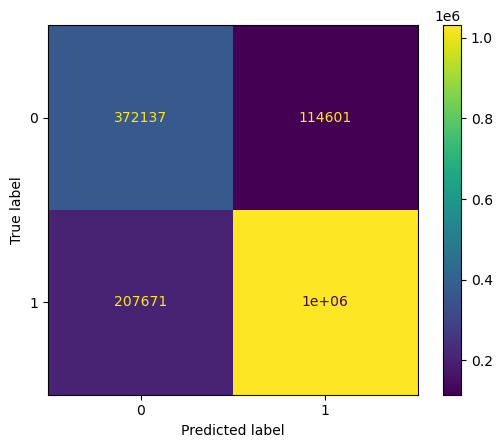

In [23]:
threshold = target_thresh

cm = confusion_matrix(cb_test_y, np.where(ppreds[:, 1] > threshold, 1, 0))
cm_display = ConfusionMatrixDisplay(cm).plot()

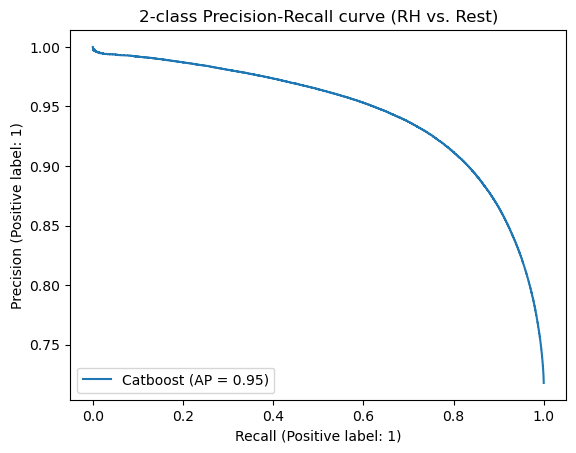

In [24]:
display = PrecisionRecallDisplay.from_predictions(cb_test_y, ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("2-class Precision-Recall curve (RH vs. Rest)")

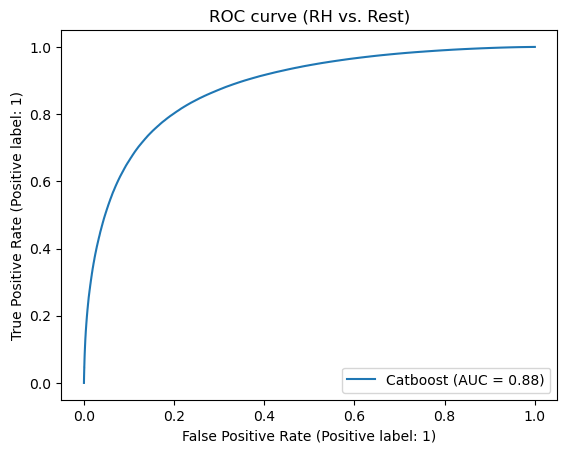

In [25]:
display = RocCurveDisplay.from_predictions(cb_test_y, ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("ROC curve (RH vs. Rest)")

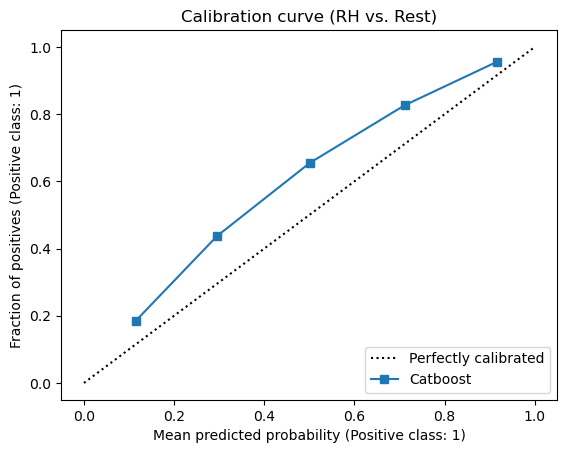

In [26]:
display = CalibrationDisplay.from_predictions(cb_test_y, ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("Calibration curve (RH vs. Rest)")

### Additional Sanity Check

In [27]:
from intent_model.functions import get_conversions

In [28]:
res_df = get_conversions(test, cb_test, model)

res_df

100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  5.81it/s]


,threshold,sa_coverage,rh_coverage,relevance
0,0.4,0.722668,0.882019,0.582306
1,0.5,0.664103,0.832459,0.606241
2,0.6,0.604158,0.773939,0.628434
3,0.7,0.534111,0.697530,0.653093
4,0.8,0.437115,0.581727,0.690339
5,0.9,0.275099,0.373819,0.772942


In [29]:
gc.collect()

6966

## User-based Split

In [30]:
users = data.customer_id.unique()
n = len(users)

train = data[data.customer_id.isin(users[:int(0.5*n)])].copy()
val = data[data.customer_id.isin(users[int(0.5*n):int(0.75*n)])].copy()
test = data[data.customer_id.isin(users[int(0.75*n):])].copy()

In [31]:
print(len(train))
print(len(val))
print(len(test))

7836294
1682432
572121


In [32]:
train.target.value_counts()

1    5947510
0    1888784
Name: target, dtype: int64

In [33]:
val.target.value_counts()

1    1140518
0     541914
Name: target, dtype: int64

In [34]:
test.target.value_counts()

1    291980
0    280141
Name: target, dtype: int64

In [35]:
train['sample_weight'] = 1.0
train.loc[(train.rh == 1) & (train.is_trip_ended == 0), 'sample_weight'] = 0.5

In [36]:
train_neg = train[train.target == 0]

train_pos, _ = train_test_split(
    train[train.target == 1],
    test_size=0.5,
    stratify=train[train.target == 1]['sample_weight'],
    random_state=111
)

train = pd.concat([train_neg, train_pos]).sample(frac=1.0).reset_index(drop=True)

In [37]:
train.target.value_counts()

1    2973755
0    1888784
Name: target, dtype: int64

In [38]:
cb_train = cb.Pool(
    train.drop(TO_DROP + ['sample_weight'], axis=1),
    label=train.target.values,
    cat_features=CAT,
    weight=train.sample_weight.values
)

cb_val = cb.Pool(
    val.drop(TO_DROP, axis=1),
    label=val.target.values,
    cat_features=CAT
)

cb_test = test.drop(TO_DROP, axis=1)
cb_test_y = test.target.values

### Model

In [39]:
param = {
    'learning_rate': 0.05,
    'depth': 10,
    'l2_leaf_reg': 4.0,
    'min_child_samples': 1,
    'langevin': True,
    'grow_policy': 'Depthwise',
    'has_time': False,
    'subsample': 0.85
}

param['iterations'] = 750
param['use_best_model'] = True
param['od_type'] = 'Iter'
param['od_wait'] = 50
param['random_state'] = 42
param['bootstrap_type']= 'Bernoulli'
param['score_function'] = 'L2'
param['verbose'] = 50


u_model = cb.CatBoostClassifier(**param)

u_model.fit(cb_train, eval_set=cb_val, use_best_model=True, early_stopping_rounds=50)
u_model.save_model('cb_models/binary_user.cbm')

0:	learn: 0.6645525	test: 0.6652196	best: 0.6652196 (0)	total: 1.48s	remaining: 18m 27s
50:	learn: 0.4422505	test: 0.4454229	best: 0.4454229 (50)	total: 56.5s	remaining: 12m 54s
100:	learn: 0.4333286	test: 0.4399108	best: 0.4399108 (100)	total: 1m 47s	remaining: 11m 30s
150:	learn: 0.4287534	test: 0.4378090	best: 0.4378090 (150)	total: 2m 33s	remaining: 10m 8s
200:	learn: 0.4248154	test: 0.4360083	best: 0.4360083 (200)	total: 3m 17s	remaining: 8m 59s
250:	learn: 0.4216544	test: 0.4347546	best: 0.4347546 (250)	total: 4m 1s	remaining: 7m 59s
300:	learn: 0.4184920	test: 0.4337414	best: 0.4337414 (300)	total: 4m 44s	remaining: 7m 4s
350:	learn: 0.4157054	test: 0.4329472	best: 0.4329472 (350)	total: 5m 26s	remaining: 6m 10s
400:	learn: 0.4126267	test: 0.4323313	best: 0.4323313 (400)	total: 6m 8s	remaining: 5m 20s
450:	learn: 0.4096039	test: 0.4316773	best: 0.4316773 (450)	total: 6m 50s	remaining: 4m 32s
500:	learn: 0.4068962	test: 0.4312573	best: 0.4312573 (500)	total: 7m 31s	remaining: 3m 

In [40]:
u_ppreds = u_model.predict_proba(cb_test)
u_preds = u_model.predict(cb_test)

### Evaluation

In [41]:
log_loss(cb_test_y, u_ppreds)

0.46828714417611733

In [42]:
roc_auc_score(cb_test_y, u_ppreds[:, 1])

0.8611060061701009

In [43]:
print(classification_report(cb_test_y, u_preds))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77    280141
           1       0.77      0.83      0.80    291980

    accuracy                           0.78    572121
   macro avg       0.79      0.78      0.78    572121
weighted avg       0.79      0.78      0.78    572121



In [44]:
dict(zip(u_model.feature_names_, u_model.get_feature_importance()))

{'latitude': 4.249576542344971,
 'longitude': 3.63948144912636,
 'quantile': 1.883292816162945,
 'min_dist_to_known_loc': 3.050009720933944,
 'known_loc_occ': 2.251948792190772,
 'dist_to_most_freq': 4.0716395948963635,
 'weekday': 0.9307726072701388,
 'minutes_sin': 5.75948162608809,
 'minutes_cos': 3.4148298609963494,
 'rh_frac': 53.26745042143963,
 'norm_week': 2.3271654289699444,
 'norm_hour': 15.154351139580506}

In [45]:
target_thresh, expected_recall = get_optimal_threshold(cb_test_y, u_ppreds[:, 1], 0.9)

print(target_thresh)
print(expected_recall)

0.8499155321819466
0.4246318240975409


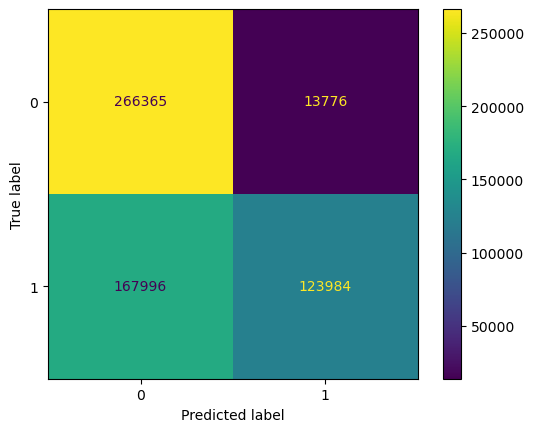

In [46]:
threshold = target_thresh

cm = confusion_matrix(cb_test_y, np.where(u_ppreds[:, 1] > threshold, 1, 0))
cm_display = ConfusionMatrixDisplay(cm).plot()

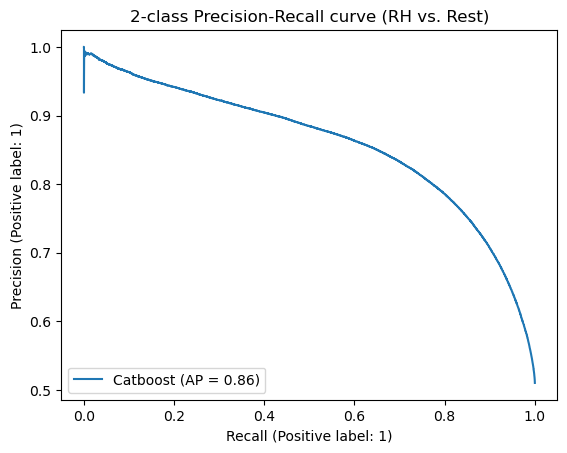

In [47]:
display = PrecisionRecallDisplay.from_predictions(cb_test_y, u_ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("2-class Precision-Recall curve (RH vs. Rest)")

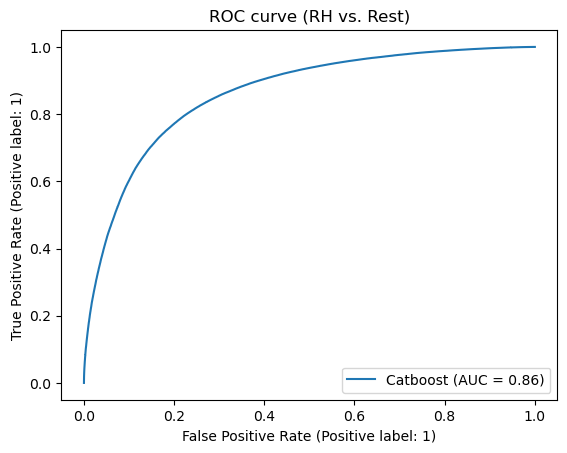

In [48]:
display = RocCurveDisplay.from_predictions(cb_test_y, u_ppreds[:, 1], name="Catboost")
_ = display.ax_.set_title("ROC curve (RH vs. Rest)")

#### "Bad" users

In [49]:
test['preds'] = u_ppreds[:, 1]
test['loss'] = -(test['target'] * np.log(test['preds']) + (1 - test['target'])*np.log(1 - test['preds']))

test_g = test[['customer_id', 'loss']].groupby('customer_id', as_index=False).mean()\
    .sort_values('loss', ascending=False)

test_g.head(10)

,customer_id,loss
40107,52673893,4.624765
63502,60104648,4.106798
71742,62049327,4.058340
47720,55426133,4.045803
57703,58748436,3.794964
42091,53323263,3.786470
62741,59893245,3.775129
5086,6240853,3.668198
58151,58855221,3.629358
22627,41649384,3.618667


<AxesSubplot: ylabel='Density'>

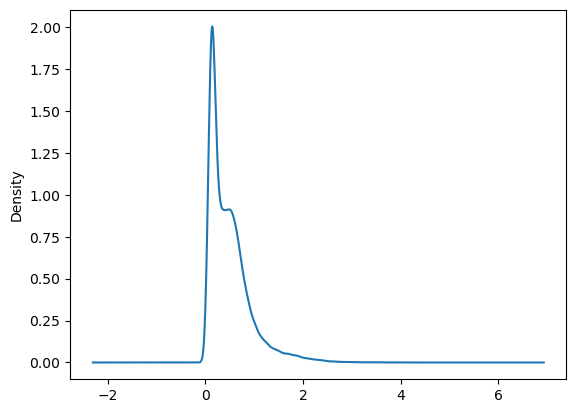

In [50]:
test_g.loss.plot(kind='kde')

In [51]:
val['preds'] = u_model.predict_proba(cb_val)[:, 1]
val['loss'] = -(val['target'] * np.log(val['preds']) + (1 - val['target'])*np.log(1 - val['preds']))

val_g = val[['customer_id', 'loss']].groupby('customer_id', as_index=False).mean()\
    .sort_values('loss', ascending=False)

val_g.head(10)

,customer_id,loss
34336,49463265,3.126964
11391,21137735,2.769525
6485,9220324,2.669016
13156,25635560,2.528004
596,116000,2.420255
45693,54167164,2.368467
35739,50263484,2.360258
79217,63565420,2.236780
40054,52272520,2.212001
66047,60515725,2.175615


<AxesSubplot: ylabel='Density'>

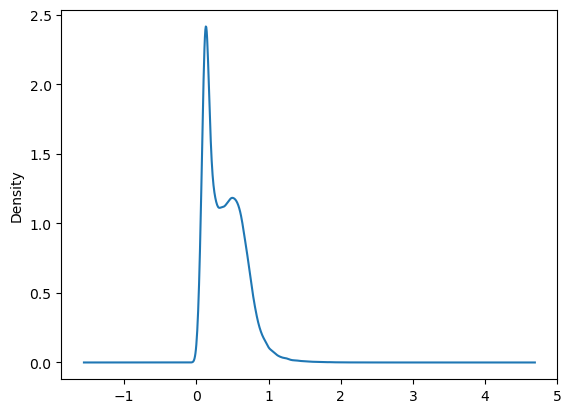

In [52]:
val_g.loss.plot(kind='kde')

In [53]:
train['preds'] = u_model.predict_proba(cb_train)[:, 1]
train['loss'] = -(train['target'] * np.log(train['preds']) + (1 - train['target'])*np.log(1 - train['preds']))

train_g = train[['customer_id', 'loss']].groupby('customer_id', as_index=False).mean()\
    .sort_values('loss', ascending=False)

train_g.head(10)

,customer_id,loss
127244,59257237,4.296490
59622,45324372,3.628333
115277,57566077,3.472531
90682,53219335,3.452891
14199,9910581,3.233353
56175,44207201,3.068390
77789,50761092,2.721518
90926,53256804,2.701277
65013,46807371,2.673435
136078,60464677,2.624440


<AxesSubplot: ylabel='Density'>

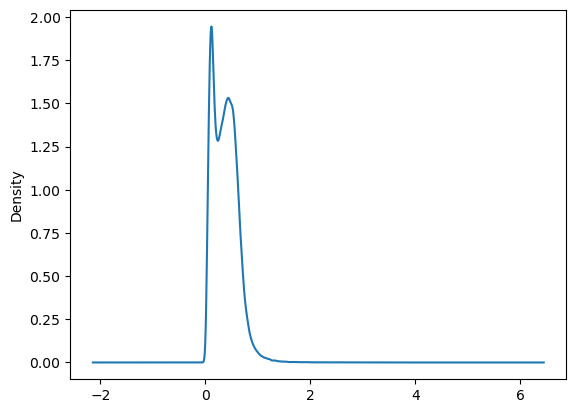

In [54]:
train_g.loss.plot(kind='kde')

### Additional Sanity Check

In [55]:
res_df = get_conversions(test, cb_test, u_model)

res_df

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 26.79it/s]


,threshold,sa_coverage,rh_coverage,relevance
0,0.4,0.614227,0.877341,0.357179
1,0.5,0.547360,0.825454,0.382384
2,0.6,0.483099,0.762254,0.406153
3,0.7,0.413683,0.680629,0.432383
4,0.8,0.319590,0.548020,0.473256
5,0.9,0.145565,0.265011,0.613165


In [56]:
gc.collect()

12194